# Example 4: Pressure robustness against future measurements

This example tests the robustness of a SimpleReservoir model against exceeding a critical pressure threshold for varying injection rates

### SETUP

For plots shown in this example we set the backend of matplotlib to the 'inline' backend (specific for Jupyter notebooks) so that result of any plotting command is displayed inline directly below the code cell that produces it.

In [1]:
%matplotlib inline

#### 1) Import the standard and third party needed libraries.

In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import interp1d

sys.path.insert(0, os.sep.join(['..', '..', 'source']))

#### 2) Import classes of NRAP-Open-IAM utilized in the example.

In [3]:
# Ignore syntax warnings
import warnings
warnings.filterwarnings(action='ignore', category=SyntaxWarning)

from openiam import SystemModel, SimpleReservoir

### FUNCTIONS

#### 3) Define function calculating robustness measure.

In [4]:
def robustness(Pc, Ps, kus):
    '''
    Calculate robustness against future measurements exceeding a critical pressure

    :param Pc: Critical pressure threshold
    :type Pc: float
    
    :param Ps: List of arrays containing the maximum pressure prediction associated
    :type Ps: list(array(float)) or array(array(float))
    
    :param kus: List of arrays of deviation from nominal in units of standard errors
    :type kus: list(array(float))
    '''
    hhats = []
    for Pn1, ku in zip(Ps, kus):
        # If the minimum max pressure for the ensemble is greater than Pc, set the robustness to zero
        if Pc < np.min(Pn1):
            hhats.append(0)
        else:
            # Create function to interpolate the horizon of uncertainty as a function of max pressure prediction
            fi = interp1d(Pn1, ku)
            hhat = fi(Pc)
            # If horizon of uncertainty is less than zero, set to zero (zero robustness).
            if hhat < 0:
                hhats.append(0)
            else: # else, set robustness to hhat
                hhats.append(hhat)
    return hhats

#### 4) Define function to create System and SimpleReservoir models

In [5]:
def sys_model(sys_kwargs, logResPerm_val, simple_res_name, injRate):
    '''
    Create system and reservoir model
    
    :param sys_kwargs: Time array for system model
    :type  sys_kwargs: Numpy array
    
    :param logResPerm_val: Log value of reservoir permeability
    :type  logResPerm_val: Int
    
    :param simple_res_name: Name of SimpleReservoir model
    :type  simple_res_name: Str
    
    :param injRate: Injection rate
    :type  injRate: Float
    
    '''
    sm = SystemModel(model_kwargs=sys_kwargs)
    
    # Add reservoir component
    sres = sm.add_component_model_object(SimpleReservoir(name=simple_res_name, parent=sm))
    
    # Add parameters of reservoir component model
    sres.add_par('logResPerm', min=-14, max=-9, value=logResPerm_val)
    sres.add_par('CO2Density', value=328.0, vary=False)
    
    # Set injection rate parameter, but do not vary
    sres.add_par('injRate', min=0.05, max=0.15, value=injRate, vary=False)
    
    # Add observations of reservoir component model
    sres.add_obs('pressure')
    
    return sm, sres

### MAIN

We would like to evaluate robustness for different injection rates. The first step is to define a model and produce some synthetic data for use in our analysis later.

#### 5) Define injection rates and convert from $Mt/y$ to $m^{3}/s$
Assuming temperature of 20$^{\circ}$C at the surface, geothermal gradient of 0.03$^{\circ}$C/m,  land surface pressure of 100000 Pa and water density at 1000 kg/m$^{3}$, the density of CO$_{2}$ in the reservoir would be around 328 kg/m$^{3}$. This can be used to then calculate the injection rate in m$^{3}$/s.

In [6]:
# Define injection rate in Mt/y
injRates_Mty = np.array([0.75, 1.0, 1.25])

# Convert injection rate to m^3/s
injRates = injRates_Mty*1.0e+9/(365.25*86400.0*328.0)

#### 6) Create synthetic observations for each value of injection rate.
Synthetic observations are created by running the system model forward with specified parameter values: reservoir permeability, injection rate and density of CO2. 

In [7]:
noisy_pressures = []
true_pressures = []

# Define array of times in days at 30 day intervals up to present (480 days)
dtime = 30  # in days
time_array = np.linspace(0, 480, int(480/dtime+1))   # list of times in days
sm_model_kwargs = {'time_array': time_array}  # define dictionary for system model with time array

for i, injRate in enumerate(injRates):
    #####################
    # CREATE NOISY DATA #
    #####################

    #Create system model up to present (480 days)
    sm, sres = sys_model(sm_model_kwargs, logResPerm_val=-11, simple_res_name='sres', injRate=injRate)
    
    # Run system model using current values of its parameters
    sm.forward()
    
    # Assign observations of the model to pressure variable
    pressure = sm.collect_observations_as_time_series(sres, 'pressure')
    
    # Add noise to data and add as observations to system model
    np.random.seed(3000+i+4)
    noisy_pressure = pressure + np.random.normal(loc=0, scale=5.0e+4, size=len(pressure))
    noisy_pressures.append(noisy_pressure)
    true_pressures.append(pressure)
    
    # For each observation value, replace it with the noisy value
    for o, n in zip(sm.obs.values(), noisy_pressure): 
        o.value = n

#### 7) Plot "True" and Noisy Data

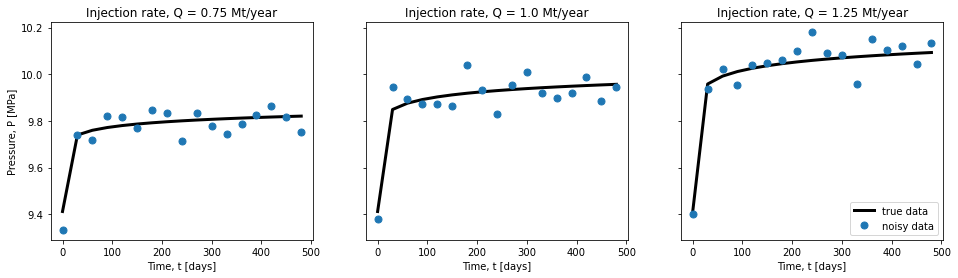

In [8]:
# Define plot parameters
line_width = 3
true_color = 'black'
noisy_color = '#1f77b4'
marker_size = 7

# Create figure
f, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 4))

# For each injection rate, plot true and noisy pressure as a function of time
for ind, injRate in enumerate(injRates):
    ax[ind].plot(time_array, true_pressures[ind]/1.0e+6, 
                 '-', color=true_color, label="true data", 
                 linewidth=line_width)
    ax[ind].plot(time_array, noisy_pressures[ind]/1.0e+6, 
                 'o', color=noisy_color, label="noisy data", 
                 markersize=marker_size)
    ax[ind].set_xlabel('Time, t [days]')
    ax[ind].set_title('Injection rate, Q = {} Mt/year'.format(injRates_Mty[ind]))

# Place y-label
ax[0].set_ylabel('Pressure, P [MPa]')

# Place legend
ax[ind].legend(loc='lower right')
plt.show()

Having produced our synthetic "true" and "noisy" data, the study proceeds as follows:
* It is assumed that conformance is being checked for all measurements after the second one is obtained (time_array[:2]).
* The following analysis is performed for each of the remaining time points (time_array[2:-1]):
    1. Fit the model with fixed injection rate to the available measurements, producing an estimate of reservoir permeability and standard error of the estimate.
    2. Using the estimated permeability, predict future pressures.
    3. Predict pressures for an ensemble of permeabilities.
    4. Calculate the number of standard errors of each k in the ensemble from the current nominal value (pf['sres.logResPerm']).
    5. Collect the max pressure for predictions for each k in the ensemble.

We perform the study described above for each value of the injection rate.

In [9]:
arr_stderrs = [] # least square standard error of perm estimate
arr_kus = [] # deviation of res perm from least square estimate divided by least square standard error
arr_kfits = []
arr_Pnps = [] # max pressure predictions for permeability samples
arr_Ps = [] # Simulated pressures for all time steps

for i, injRate in enumerate(injRates):
    print('Injecton rate', injRate)
    stderrs = [] # least square standard error of perm estimate
    kus = [] # deviation of res perm from least square estimate divided by least square standard error
    kfits = []
    Pnps = [] # max pressure predictions for permeability samples
    Ps = [] # Simulated pressures for all time step
    
    # For an increasing length of time beginning at dtime*2 and ending at last time point
    for t in time_array[2:-1]:
        
        # Determine value of logResPerm that best fits to the pressure data points available within the time provided
        
        # Define array of times in days at 30 day intervals up to current time (t+1)
        t_s = np.arange(0, t+1, dtime) # list of times in days
        print('Time t = ', t, 'array:', t_s) # print list of times in days
        sm1_model_kwargs = {'time_array': t_s}  # define dictionary for system model with time array
        
        # Create system model with observations at the first (t+1)/30 time points
        sm1, sres1 = sys_model(sm1_model_kwargs, logResPerm_val=-10.5, simple_res_name='sres', injRate=injRate)
        
        # Replace system model pressure observations with noisy pressures calculated previously
        for o, n in zip(sm1.obs.values(), noisy_pressures[i]): 
            o.value = n
        
        # Perform least squares fit for current system model to determine logResPerm optimal value
        lf, pf = sm1.lmfit(report_fit=False, difference_type='central')
        
        # Print results of least squares fit for logResPerm optimal value
        print("Least Squares Fit Value  for logResPerm: {}".format(pf['sres.logResPerm'].value))
        print("Least Squares Fit StdErr for logResPerm: {}\n\n".format(pf['sres.logResPerm'].stderr))
        
        # Store logResPerm optimal value and stderr
        kfits.append(pf['sres.logResPerm'].value)
        stderrs.append(pf['sres.logResPerm'].stderr)
        
        # Run system model using current values of its parameters to ensure that optimal pressures are in observations
        sm1.forward()

        # Create system model with all times to predict future pressures to perform robustness analysis
        # This new system model utilizes the "optimized" logResPerm from the least squares fit
        sm2, sres2 =sys_model(sm_model_kwargs, kfits[-1], 'sres', injRate)

        # Replace all pressure observations with noisy pressure values
        for o, n in zip(sm2.obs.values(), noisy_pressures[i]): 
            o.value = n
            
        # Run model forward to collect predicted pressures
        Ps.append(np.array(list(sm2.forward().values())))

        # Run sampleset of reservoir perms
        ks = np.linspace(-10., -13., 21)
        ss = sm2.create_sampleset(ks.reshape(21, 1))
        ss.run(verbose=False)
        
        # Calculate robustnesses
        kus.append((pf['sres.logResPerm'].value - ks)/stderrs[-1])

        # Collect pressure predictions
        Pnames = [v for v in ss.responses.recarray.dtype.names if v not in sm1.obsnames]

        # Collect max pressure predictions for each ks and convert to MPa
        Pnps.append(np.max(ss.responses.recarray[Pnames].tolist(), axis=1)/1.0e6)

        # Remove unnecessary variables
        del sm1, sm2, ss, lf, pf
    arr_stderrs.append(stderrs)
    arr_kus.append(kus)
    arr_kfits.append(kfits)
    arr_Pnps.append(Pnps)
    arr_Ps.append(Ps)

Injecton rate 0.07245751786744424
Time t =  60.0 array: [ 0. 30. 60.]
Least Squares Fit Value  for logResPerm: -10.967563610553134
Least Squares Fit StdErr for logResPerm: 0.15370601413533252


Time t =  90.0 array: [ 0. 30. 60. 90.]
Least Squares Fit Value  for logResPerm: -11.002735136030125
Least Squares Fit StdErr for logResPerm: 0.11276137180793631


Time t =  120.0 array: [  0.  30.  60.  90. 120.]
Least Squares Fit Value  for logResPerm: -11.014553534436075
Least Squares Fit StdErr for logResPerm: 0.08431999407742563


Time t =  150.0 array: [  0.  30.  60.  90. 120. 150.]
Least Squares Fit Value  for logResPerm: -11.006533741633831
Least Squares Fit StdErr for logResPerm: 0.06952577035698033


Time t =  180.0 array: [  0.  30.  60.  90. 120. 150. 180.]
Least Squares Fit Value  for logResPerm: -11.01802506087281
Least Squares Fit StdErr for logResPerm: 0.06071976951027276


Time t =  210.0 array: [  0.  30.  60.  90. 120. 150. 180. 210.]
Least Squares Fit Value  for logResPerm: 

Least Squares Fit Value  for logResPerm: -11.008170603219348
Least Squares Fit StdErr for logResPerm: 0.024607742716061788




### RESULTS

#### 8) Plot of robustness over time for different injection rates

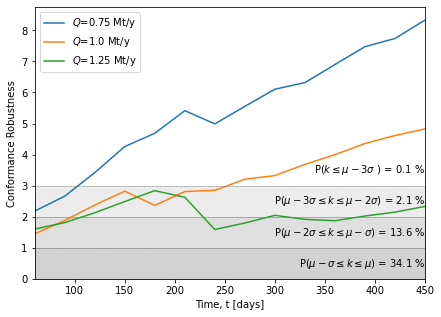

In [10]:
# Define plots parameters
area_color = 'gray'
horiz_align = 'right'

# Define plot
f, ax = plt.subplots(1, figsize=(7, 5))
for aPnps, akus, injRate, injRate_Mty in zip(arr_Pnps, arr_kus, injRates, injRates_Mty):
    ax.plot(time_array[2:-1], robustness(10.2, aPnps, akus), label=r'$Q$={} Mt/y'.format(injRate_Mty))
ax.fill_between(time_array[2:-1], 0, 1, color=area_color, alpha=0.35)
ax.fill_between(time_array[2:-1], 1, 2, color=area_color, alpha=0.25)
ax.fill_between(time_array[2:-1], 2, 3, color=area_color, alpha=0.15)
ax.legend()
ax.set_xlabel('Time, t [days]')
ax.set_ylabel('Conformance Robustness')
ax.axhline(1, ls='--', lw=0.5, c='grey')
ax.text(450, 0.4, r'P($\mu-\sigma \leq k \leq \mu$) = 34.1 %', ha=horiz_align)
ax.axhline(2, ls='--', lw=0.5, c='grey')
ax.text(450, 1.4, r'P($\mu-2\sigma\leq k \leq \mu-\sigma$) = 13.6 %', ha=horiz_align)
ax.axhline(3, ls='--', lw=0.5, c='grey')
ax.text(450, 2.4, r'P($\mu-3\sigma\leq k \leq \mu-2\sigma$) = 2.1 %', ha=horiz_align)
ax.text(450, 3.4, r'P($k \leq \mu-3\sigma$ ) = 0.1 %', ha=horiz_align)
ax.set_xlim(60, time_array[-2])
ax.set_ylim(bottom=0)
plt.show()

#### 9) Plot of results for injection rate Q=1 Mt/year

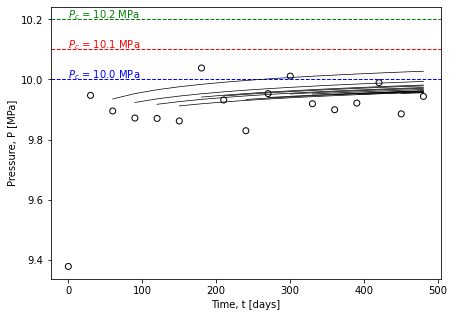

In [11]:
# Setup plot parameters
line_color = 'black'
data_color = 'black'
bot_line_color = 'blue'
mid_line_color = 'red'
top_line_color = 'green'
thres_line_width = 1

# Plot measured pressures
f, ax = plt.subplots(1, figsize=(7, 5))
ax.scatter(time_array, noisy_pressures[1]/1.0e+6, label='noisy pressure', 
           edgecolors=data_color, facecolors="None")

# Plot critical pressure thresholds
ax.axhline(10.0, ls='--', c=bot_line_color, lw=thres_line_width)
ax.axhline(10.1, ls='--', c=mid_line_color, lw=thres_line_width)
ax.axhline(10.2, ls='--', c=top_line_color, lw=thres_line_width)
ax.set_xlabel('Time, t [days]')
ax.set_ylabel('Pressure, P [MPa]')
ax.text(0., 10.005, r'$P_c$ = 10.0 MPa', color=bot_line_color)
ax.text(0., 10.105, r'$P_c$ = 10.1 MPa', color=mid_line_color)
ax.text(0., 10.205, r'$P_c$ = 10.2 MPa', color=top_line_color)

# Plot only predicted pressures, skipping pressure up to the time the fit is performed
for i, P in enumerate(arr_Ps[1]): 
    ax.plot(time_array[2+i:], P[2+i:]/1.0e+6, lw=0.7, c=line_color)

#### 10) Plot of the standard error of the estimate over time as more measurements become available

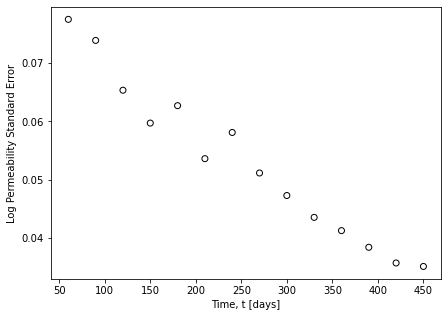

In [12]:
f, ax = plt.subplots(1, figsize=(7, 5))
ax.scatter(time_array[2:-1], arr_stderrs[1], facecolors="None", edgecolors='k')
ax.set_xlabel('Time, t [days]')
ax.set_ylabel('Log Permeability Standard Error')
plt.show()

#### 11) Plot of permeability estimates with standard error bars over time as more measurements are obtained

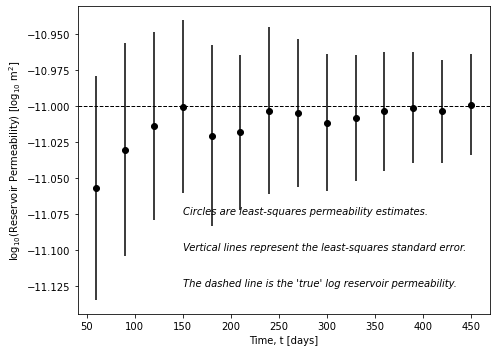

In [13]:
font_style = 'italic'
f, ax = plt.subplots(1, figsize=(7, 5))
ax.errorbar(time_array[2:-1], arr_kfits[1], yerr=arr_stderrs[1], fmt='ko')
ax.set_xlabel('Time, t [days]')
ax.set_ylabel(r'log$_{10}$(Reservoir Permeability) [log$_{10}$ m$^2$]')
ax.axhline(-11, ls='--', c='k', lw=1)
ax.text(150, -11.075, 'Circles are least-squares permeability estimates.', style=font_style)
ax.text(150, -11.100, 'Vertical lines represent the least-squares standard error.', style=font_style)
ax.text(150, -11.125, "The dashed line is the 'true' log reservoir permeability.", style=font_style)
f.tight_layout()

#### 12) Plot of robustness over time for different critical pressures

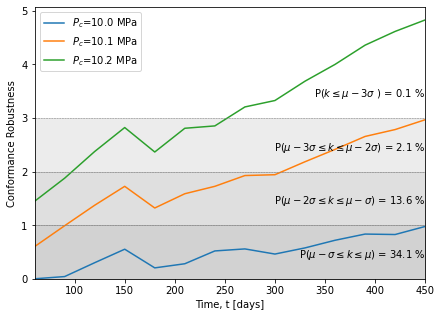

In [14]:
f, ax = plt.subplots(1, figsize=(7, 5))
for Pc in [10.0, 10.1, 10.2]:
    ax.plot(time_array[2:-1], robustness(Pc, arr_Pnps[1], arr_kus[1]), label=r'$P_c$='+str(Pc)+' MPa')
ax.fill_between(time_array[2:-1], 0, 1, color='gray', alpha=0.35)
ax.fill_between(time_array[2:-1], 1, 2, color='gray', alpha=0.25)
ax.fill_between(time_array[2:-1], 2, 3, color='gray', alpha=0.15)
ax.legend()
ax.set_xlabel('Time, t [days]')
ax.set_ylabel('Conformance Robustness')
ax.axhline(1, ls='--', lw=0.5, c='grey')
ax.text(450, 0.4, r'P($\mu-\sigma \leq k \leq \mu$) = 34.1 %', ha='right')
ax.axhline(2, ls='--', lw=0.5, c='grey')
ax.text(450, 1.4, r'P($\mu-2\sigma\leq k \leq \mu-\sigma$) = 13.6 %', ha='right')
ax.axhline(3, ls='--', lw=0.5, c='grey')
ax.text(450, 2.4, r'P($\mu-3\sigma\leq k \leq \mu-2\sigma$) = 2.1 %', ha='right')
ax.text(450, 3.4, r'P($k \leq \mu-3\sigma$ ) = 0.1 %', ha='right')
ax.set_xlim(60, time_array[-2])
ax.set_ylim(bottom=0)
plt.show()

#### 13) Setup system model and plot pressure prediction bands as more monitoring data is collected

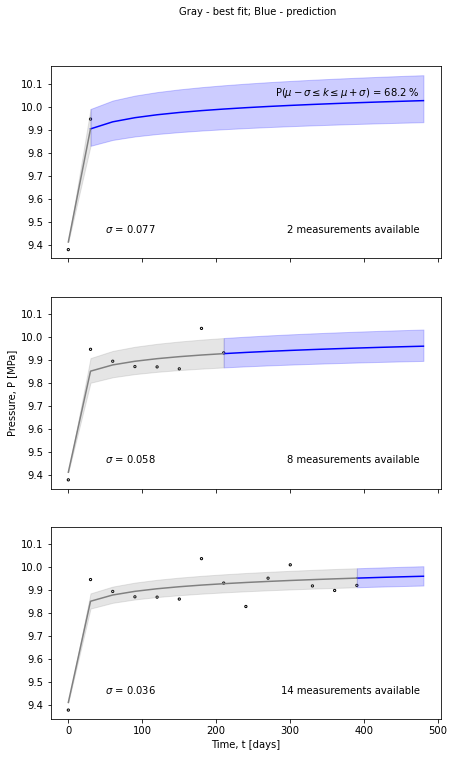

In [15]:
sm = SystemModel(model_kwargs={'time_array': time_array})
sres = sm.add_component_model_object(SimpleReservoir(name='sres', parent=sm))
# Add parameters of reservoir component model
sres.add_par('logResPerm', min=-14, max=-9, value=kfits[-1])
# Set injection rate parameter, but do not vary
sres.add_par('injRate', min=0.05, max=0.15, value=injRates[1], vary=False)
# Add observations of reservoir component model
sres.add_obs('pressure')
# Collect pressures from model with best fit k and best fit k plus and minus the standard error
f, ax = plt.subplots(3, sharey=True, sharex=True, figsize=(7, 12))
for axi, i in enumerate([0, 6, 12]):
    pu = sm.forward(pardict={'sres.logResPerm': arr_kfits[1][i]+arr_stderrs[1][i]})
    p = sm.forward(pardict={'sres.logResPerm': arr_kfits[1][i]})
    pl = sm.forward(pardict={'sres.logResPerm': arr_kfits[1][i]-arr_stderrs[1][i]})
    ax[axi].scatter(time_array[:2+i], noisy_pressures[1][:2+i]/1.0e6, 5, 
                    label='noisy pressure', edgecolors='k', facecolors="None")
    ax[axi].plot(time_array[1+i:], np.array(list(p.values())[1+i:])/1.0e+6, color='blue')
    ax[axi].fill_between(time_array[1+i:], np.array(list(pu.values())[1+i:])/1.0e6, 
                         np.array(list(pl.values())[1+i:])/1.0e+6, color='blue', alpha=0.20)
    ax[axi].plot(time_array[:2+i],np.array(list(p.values())[:2+i])/1.0e+6, color='gray')
    ax[axi].fill_between(time_array[:2+i], np.array(list(pu.values())[:2+i])/1.0e6, 
                         np.array(list(pl.values())[:2+i])/1.0e+6, color='gray', alpha=0.20)
    ax[axi].text(50, 9.45, r'$\sigma$ = '+str(np.round(arr_stderrs[1][i], decimals=3)))
ax[0].text(475, 9.45, r'2 measurements available', ha='right')
ax[0].text(475, 10.05, r'P($\mu-\sigma \leq k \leq \mu+\sigma$) = 68.2 %', ha='right')
ax[1].text(475, 9.45, r'8 measurements available', ha='right')
ax[0].text(150, 10.4, r'Gray - best fit; Blue - prediction')
ax[2].text(475, 9.45, r'14 measurements available', ha='right')
ax[2].set_xlabel('Time, t [days]')
ax[1].set_ylabel('Pressure, P [MPa]')
plt.show()
